In [41]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [42]:
panels_df = pd.read_csv("../output/all_panels.csv", index_col=0)

In [43]:
panels_df.head()

,machine_id,household_income,racial_background,stratify,panel_id
0,217187453.0,1,1.0,"1.0, 1.0",0
1,161205582.0,1,1.0,"1.0, 1.0",0
2,228664045.0,1,1.0,"1.0, 1.0",0
3,206048074.0,1,1.0,"1.0, 1.0",0
4,225801506.0,1,1.0,"1.0, 1.0",0


In [44]:
N_machines = panels_df.groupby('panel_id')['machine_id'].count()[0]
print("\n%s = N machines per panel" % N_machines)


12146 = N machines per panel


We know from exploring the sessions data that only about 35-40% machines have at least 7 domains each week. How many cohorts if cohort size K=50, ...

In [45]:
K = 50
print('max expected number of cohorts if K = %s ?' % K)
print(0.36*panels_df.groupby('panel_id')['machine_id'].count()[0] / K)
K = 100
print('max expected number of cohorts if K = %s ?' % K)
print(0.36*panels_df.groupby('panel_id')['machine_id'].count()[0] / K)

max expected number of cohorts if K = 50 ?
87.45119999999999
max expected number of cohorts if K = 100 ?
43.72559999999999


We use a library developed to replicate chrome FLoC cohorts for the origin trial.

We just use the simhash function from this library. We briefly test its full simulation functionality, which uses that simhash, to show it correctly replicates the cohort ID.

In [46]:
import floc

# sanity check: The same host list used in the GO and python implementations generate
# the same cohort ID
host_list = [
    'www.nikkei.com',
    'jovi0608.hatenablog.com',
    'www.nikkansports.com',
    'www.yahoo.co.jp',
    'www.sponichi.co.jp',
    'www.cnn.co.jp',
    'floc.glitch.me',
    'html5.ohtsu.org',
]
assert(floc.simulate(host_list) == 21454)

In [47]:
# here is an example of a domain list for a cohort deemed sensitive
sensitive_cohort_domain_list = [
    "www.dominos.com",
    "shop.lululemon.com",
    "www.homedepot.com",
    "www.ticketliquidator.com",
    "www.livenation.com",
    "www.tracfone.com",
    "www.officedepot.com"
]
try:
    floc.simulate(sensitive_cohort_domain_list)
except Exception as e:
    print("SimulateError:", e)
floc.simulate(sensitive_cohort_domain_list, check_sensiveness=False)

SimulateError: blocked


24884

## Compute cohorts

### Compute fake cohorts with transactions data

Make table mapping machine_ids to domains.

TODO: update this step to use the real sessions data (once we have it)

Here we make fake sessions/domains data, by using the transactions data. Here the domains are the domains where the transactions for a user were made.

But we need at least 7 domains and most user data is sparse... so we insert more domains into a user's weekly domain history.

In [14]:
transactions_fpath = '../data/comscore/2017/transactions.csv'
transactions_df = pd.read_csv(transactions_fpath,
                              parse_dates=['event_date'],
                              encoding="ISO-8859-1")[
    ['machine_id', 'event_date', 'domain_name']
]
(transactions_df
 .drop('machine_id',axis=1)
 .dropna()
).head()

/Users/aberke/projects/floc-analysis/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,event_date,domain_name
25,2017-01-04,verizonwireless.com
26,2017-03-22,verizonwireless.com
27,2017-01-07,verizonwireless.com
28,2017-03-13,verizonwireless.com
29,2017-02-28,verizonwireless.com


In [15]:
tdf = (transactions_df
 .assign(week=lambda x: x.event_date.dt.week)
 .dropna()
 .groupby(['machine_id', 'week'])
 .agg({'domain_name': set}).reset_index()
       .assign(n_domains=lambda x: x.domain_name.map(len))
       .assign(domain_name=lambda x: x.domain_name.map(lambda y: "|".join(list(y))))
      )

/Users/aberke/projects/floc-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [16]:
(tdf
 .sort_values('n_domains', ascending=False)
 .drop('machine_id', axis=1)
).head(10)

,week,domain_name,n_domains
24571,10,nordstromrack.com|amazon.com|expedia.com|ebay....,8
40382,12,avis.com|amazon.com|budget.com|expedia.com|orb...,7
22464,1,southwest.com|nordstrom.com|bestwestern.com|hy...,7
22470,7,bestbuy.com|nordstromrack.com|amazon.com|dicks...,6
13162,1,carters.com|amazon.com|gap.com|sephora.com|6pm...,6
1275,5,overstock.com|amazon.com|etsy.com|walmart.com|...,5
11114,4,booking.com|bestwestern.com|ticketmaster.com|t...,5
22543,1,hertz.com|amazon.com|dsw.com|searspartsdirect....,5
24967,10,disneystore.com|shutterfly.com|qvc.com|kohls.c...,5
17162,8,shutterfly.com|carters.com|officedepot.com|gap...,5


There are not enough domains per machine ^.

Pad the domain histories for each machine to have at least 7 per machine.

In [17]:
import itertools
unique_domains = list(set(itertools.chain(*[d.split("|") for d in tdf.domain_name])))

def pad_domains(l, s):
    n = 7 - len(l)
    if n > 0:
        return list(l) + list(np.random.choice(s, n))
    else:
        return l

tdf['padded_domains'] = tdf.apply(lambda x: pad_domains(x.domain_name.split("|"), unique_domains), axis=1)

In [18]:
(tdf
 .sort_values('n_domains', ascending=False)
 .drop('machine_id', axis=1)
).head(5)

,week,domain_name,n_domains,padded_domains
24571,10,nordstromrack.com|amazon.com|expedia.com|ebay....,8,"[nordstromrack.com, amazon.com, expedia.com, e..."
40382,12,avis.com|amazon.com|budget.com|expedia.com|orb...,7,"[avis.com, amazon.com, budget.com, expedia.com..."
22464,1,southwest.com|nordstrom.com|bestwestern.com|hy...,7,"[southwest.com, nordstrom.com, bestwestern.com..."
22470,7,bestbuy.com|nordstromrack.com|amazon.com|dicks...,6,"[bestbuy.com, nordstromrack.com, amazon.com, d..."
13162,1,carters.com|amazon.com|gap.com|sephora.com|6pm...,6,"[carters.com, amazon.com, gap.com, sephora.com..."


### Apply simhash

Using steps from https://github.com/shigeki/floc_simulator/blob/292fe1beb8a827f27a96dc951345a5c1cfb8da56/demos/floc_sample/main.go

```
var kMaxNumberOfBitsInFloc uint8 = 50
sim_hash := floc.SimHashString(domain_list, kMaxNumberOfBitsInFloc)
```

In [19]:
kMaxNumberOfBitsInFloc = 50
floc.hashes.sim_hash_string

<function floc.hashes.sim_hash_string(domains: List[str], k_max_numbers_of_bits_in_floc: int = 50) -> int>

In [20]:
tdf['simhash'] = tdf.padded_domains.apply(floc.hashes.sim_hash_string)
(tdf
 .sort_values('simhash', ascending=False)
 .drop(['machine_id', 'week'], axis=1)
).head(5)

,domain_name,n_domains,padded_domains,simhash
9730,walmart.com,1,"[walmart.com, rei.com, potterybarn.com, alamo....",1125844243882986
15366,walmart.com,1,"[walmart.com, fragrancenet.com, cheaptickets.c...",1125844220817417
37462,amazon.com,1,"[amazon.com, dickssportinggoods.com, walmart.c...",1125613187633746
14,alamo.com,1,"[alamo.com, aa.com, weightwatchers.com, llbean...",1125150976982634
6382,southwest.com,1,"[southwest.com, vitacost.com, safeway.com, liv...",1124991270365285


Assign cohort IDs by applying the prefixLSH algorithm on all of the eligible machines in the panel.

Note: In the browser implementation, the sorting has already been done and the browser has a clusters data file. The browser then queries for the specific cohort ID for a machine based on this clusters data.

This is necessary for the real-world deployment.

The clusters data file is not necessary for this analysis.

Here we do the sorting and assignment together.

In [21]:
import prefixLSH

In [22]:
def binary_hash(h):
    return np.binary_repr(h, width=kMaxNumberOfBitsInFloc)

In [23]:
simhashes = tdf['simhash']
print(np.binary_repr(simhashes[0]))
print(len(np.binary_repr(simhashes[0])))

# some sanity checks

# check that all simhashes have binary representation less than 50 bits
for _i, simhash in enumerate(simhashes):
    assert(len(np.binary_repr(simhash)) <= 50)
    
# check that the ordering of the simhashes is the same for binary
# actually this will only work when we pad the higher bits with zeros
# as in the binary_hash implementation
sorted_simhashes = sorted(simhashes)
for i in range(1, len(simhashes)):
    assert(binary_hash(sorted_simhashes[i-1]) <= binary_hash(sorted_simhashes[i]))
    assert(sorted_simhashes[i-1] <= sorted_simhashes[i])
    
# sorted_simhashes

10011100100011110111010111000100001010100000011100
50


Get a mapping from the simhashes to their cohorts, where this is determined by sorting all of the simhashes with prefixLSH.

In [24]:
cohorts_dict = prefixLSH.get_cohorts_dict(tdf['simhash'])
tdf["cohort"] = tdf['simhash'].map(cohorts_dict)

print("%s cohorts" % tdf["cohort"].nunique())
assert(tdf["cohort"].max() == tdf["cohort"].nunique())

print("%s samples (rows)" % len(tdf))
print("%0.1f avg samples per cohort" % (len(tdf)/tdf["cohort"].nunique()))

tdf.head()

462 cohorts
43880 samples (rows)
95.0 avg samples per cohort


,machine_id,week,domain_name,n_domains,padded_domains,simhash,cohort
0,46569906,8,amazon.com,1,"[amazon.com, collectionsetc.com, abebooks.com,...",688559880185884,348
1,46569906,12,nordstromrack.com|amazon.com,2,"[nordstromrack.com, amazon.com, epson.com, int...",486253574150366,280
2,70298839,12,ebay.com,1,"[ebay.com, carters.com, kohls.com, ticketmaste...",45097856270790,29
3,100607252,11,dominos.com,1,"[dominos.com, finishline.com, nike.com, travel...",667142577893807,343
4,119721244,8,amazon.com,1,"[amazon.com, sears.com, audible.com, petco.com...",185520311225340,133


98     237
452    233
335    228
218    215
224    211
      ... 
248     51
161     51
80      50
278     50
74      50
Name: cohort, Length: 462, dtype: int64

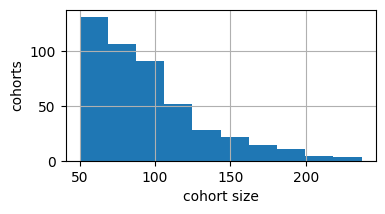

In [25]:
fig,ax = plt.subplots(1,1,figsize=(4,2), dpi=100)
tdf["cohort"].value_counts().hist(ax=ax)
plt.ylabel("cohorts")
plt.xlabel("cohort size")

tdf["cohort"].value_counts()

### Using random data

TODO:
assign random sets of domains to machines and check the relationship / distribution of cohort assignments and demographics.

### Using sessions data

#### Load in preprocessed sessions data

In [26]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
    
def read_weeks_machines_domains(nrows=None):
    """
    Reads csv mapping machine_id, week to domains.
    Returns data frame with columns:
    machine_id, week, n_domains, domains
    where domains is a list
    """
    print('reading from %s...' % weeks_machines_domains_fpath)
    df = pd.read_csv(weeks_machines_domains_fpath, nrows=nrows)
    df['domains'] = df.fillna('').domains_str.apply(lambda x: x.split('|'))
    df.drop('domains_str', axis=1, inplace=True)
    print('... read %s rows' % len(df))
    return df

In [27]:
weeks_machines_domains_df = read_weeks_machines_domains()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [28]:
print(len(weeks_machines_domains_df))
weeks_machines_domains_df.drop('machine_id', axis=1).head()

4877236


,week,n_domains,domains
0,1,119,"[homeworkmarket.com, shareably.net, crschools...."
1,1,0,[]
2,1,2,"[nbcsports.com, google.com]"
3,1,5,"[signaturesalon.us, tasteofhome.com, facebook...."
4,1,8,"[myway.com, victoryoutreach.org, adobeconnect...."


In [29]:
n_domains_threshold = 7

### PROBLEM to fix

TLDR;

There are many domains in the domains lists that are not valid eTLD+1's. They are instead just suffixes that can look like eTLD+1's (e.g. blogspot.com).

This causes the simhash function to throw an error.

These domains must be removed.


###### Notes


Error thrown when applying sim_hash_string we keep getting an error at 

https://github.com/thepabloaguilar/floc/blob/b5d6b0b5e53f660175b5fa4ca3acb45fec403b53/floc_simulator/main.go#L44


where the error says that a domain in the domains list is not a proper eTLD+1
```
"publicsuffix: cannot derive eTLD+1 for domain "blogspot.com"
```

For example, `blogspot.com` is in this list: https://publicsuffix.org/list/public_suffix_list.dat

And this list is used by the go package that determines whether the domain is eTLD+1: https://pkg.go.dev/golang.org/x/net/publicsuffix

The part of the publicSuffixList implementation that causes the error is here: 
```
eTLDPlusOne, err := publicsuffix.EffectiveTLDPlusOne(host)
```
--> 
https://cs.opensource.google/go/x/net/+/d83791d6:publicsuffix/list.go;l=167

In [30]:
domains_set = set()
for i, domains in weeks_machines_domains_df['domains'].items():
    if i % 100000 == 0:
        print('%s/%s' % (i, len(weeks_machines_domains_df['domains'])))
    domains_set.update(set(domains))

0/4877236
100000/4877236
200000/4877236
300000/4877236
400000/4877236
500000/4877236
600000/4877236
700000/4877236
800000/4877236
900000/4877236
1000000/4877236
1100000/4877236
1200000/4877236
1300000/4877236
1400000/4877236
1500000/4877236
1600000/4877236
1700000/4877236
1800000/4877236
1900000/4877236
2000000/4877236
2100000/4877236
2200000/4877236
2300000/4877236
2400000/4877236
2500000/4877236
2600000/4877236
2700000/4877236
2800000/4877236
2900000/4877236
3000000/4877236
3100000/4877236
3200000/4877236
3300000/4877236
3400000/4877236
3500000/4877236
3600000/4877236
3700000/4877236
3800000/4877236
3900000/4877236
4000000/4877236
4100000/4877236
4200000/4877236
4300000/4877236
4400000/4877236
4500000/4877236
4600000/4877236
4700000/4877236
4800000/4877236


In [31]:
print('%s unique domains' % len(domains_set))

4352338 unique domains


Collect the bad domains.

In [32]:
def get_bad_domains(domains):
    """
    Returns list of 'bad' domains.
    Where 'bad' domains are those where the floc simhash function throws an error
    because the domains are not eTLD+1's.
    """
    bad_domains_set = set()
    for i, d in enumerate(domains):
        if i % 10000 == 0:
            print('%s/%s' % (i, len(domains)))
        try:
            floc.hashes.sim_hash_string([d])
        except Exception as e:
            print(str(e))
            bad_domains_set.add(d)
    return bad_domains_set

In [33]:
bad_domains = get_bad_domains(domains_set)
print('%s bad domains' % len(bad_domains))
bad_domains

0/4352338
publicsuffix: cannot derive eTLD+1 for domain ""
publicsuffix: cannot derive eTLD+1 for domain "web.tr"
publicsuffix: cannot derive eTLD+1 for domain "podlasie.pl"
publicsuffix: cannot derive eTLD+1 for domain "gov.pr"
publicsuffix: cannot derive eTLD+1 for domain "rec.br"
publicsuffix: cannot derive eTLD+1 for domain "k12.ne.us"
publicsuffix: cannot derive eTLD+1 for domain "edu.om"
10000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mil.uy"
publicsuffix: cannot derive eTLD+1 for domain "edu.cn"
20000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mil.ph"
publicsuffix: cannot derive eTLD+1 for domain "homeunix.com"
publicsuffix: cannot derive eTLD+1 for domain "gov.qa"
30000/4352338
publicsuffix: cannot derive eTLD+1 for domain "edu.az"
publicsuffix: cannot derive eTLD+1 for domain "gov.zm"
40000/4352338
publicsuffix: cannot derive eTLD+1 for domain "me.us"
publicsuffix: cannot derive eTLD+1 for domain "en.it"
publicsuffix: cannot derive eTLD+1 for domain "n

publicsuffix: cannot derive eTLD+1 for domain "jp.net"
publicsuffix: cannot derive eTLD+1 for domain "ringsaker.no"
420000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mi.th"
430000/4352338
publicsuffix: cannot derive eTLD+1 for domain "edu.np"
publicsuffix: cannot derive eTLD+1 for domain "id.au"
440000/4352338
publicsuffix: cannot derive eTLD+1 for domain "pulawy.pl"
publicsuffix: cannot derive eTLD+1 for domain "noip.us"
450000/4352338
460000/4352338
publicsuffix: cannot derive eTLD+1 for domain "ed.ao"
publicsuffix: cannot derive eTLD+1 for domain "gov.ph"
publicsuffix: cannot derive eTLD+1 for domain "mil.kr"
470000/4352338
publicsuffix: cannot derive eTLD+1 for domain "lodi.it"
publicsuffix: cannot derive eTLD+1 for domain "pesaro-urbino.it"
publicsuffix: cannot derive eTLD+1 for domain "fl.us"
publicsuffix: cannot derive eTLD+1 for domain "debian.net"
publicsuffix: cannot derive eTLD+1 for domain "cuneo.it"
480000/4352338
publicsuffix: cannot derive eTLD+1 for domain "

870000/4352338
publicsuffix: cannot derive eTLD+1 for domain "edu.krd"
publicsuffix: cannot derive eTLD+1 for domain "gov.gd"
publicsuffix: cannot derive eTLD+1 for domain "kharkiv.ua"
880000/4352338
publicsuffix: cannot derive eTLD+1 for domain "media.pl"
publicsuffix: cannot derive eTLD+1 for domain "k12.tr"
publicsuffix: cannot derive eTLD+1 for domain "yn.cn"
890000/4352338
publicsuffix: cannot derive eTLD+1 for domain "fg.it"
publicsuffix: cannot derive eTLD+1 for domain "blogspot.de"
publicsuffix: cannot derive eTLD+1 for domain "freedesktop.org"
publicsuffix: cannot derive eTLD+1 for domain "gov.ac"
publicsuffix: cannot derive eTLD+1 for domain "gov.sh"
900000/4352338
publicsuffix: cannot derive eTLD+1 for domain "ponpes.id"
publicsuffix: cannot derive eTLD+1 for domain "info.na"
publicsuffix: cannot derive eTLD+1 for domain "gov.ps"
910000/4352338
publicsuffix: cannot derive eTLD+1 for domain "selfip.net"
publicsuffix: cannot derive eTLD+1 for domain "if.ua"
publicsuffix: canno

publicsuffix: cannot derive eTLD+1 for domain "gov.bs"
publicsuffix: cannot derive eTLD+1 for domain "ap.it"
1330000/4352338
publicsuffix: cannot derive eTLD+1 for domain "info.ro"
1340000/4352338
publicsuffix: cannot derive eTLD+1 for domain "go.it"
publicsuffix: cannot derive eTLD+1 for domain "nom.al"
publicsuffix: cannot derive eTLD+1 for domain "cloudfunctions.net"
publicsuffix: cannot derive eTLD+1 for domain "swidnica.pl"
publicsuffix: cannot derive eTLD+1 for domain "uz.ua"
1350000/4352338
publicsuffix: cannot derive eTLD+1 for domain "wroclaw.pl"
1360000/4352338
publicsuffix: cannot derive eTLD+1 for domain "blogspot.jp"
publicsuffix: cannot derive eTLD+1 for domain "gov.sc"
1370000/4352338
publicsuffix: cannot derive eTLD+1 for domain "ath.cx"
1380000/4352338
1390000/4352338
publicsuffix: cannot derive eTLD+1 for domain "nsn.us"
publicsuffix: cannot derive eTLD+1 for domain "jgora.pl"
publicsuffix: cannot derive eTLD+1 for domain "pointto.us"
publicsuffix: cannot derive eTLD+

1800000/4352338
publicsuffix: cannot derive eTLD+1 for domain "eu.com"
publicsuffix: cannot derive eTLD+1 for domain "tv.it"
publicsuffix: cannot derive eTLD+1 for domain "fi.cr"
publicsuffix: cannot derive eTLD+1 for domain "prato.it"
publicsuffix: cannot derive eTLD+1 for domain "bedzin.pl"
1810000/4352338
publicsuffix: cannot derive eTLD+1 for domain "blogspot.sg"
publicsuffix: cannot derive eTLD+1 for domain "pro.br"
publicsuffix: cannot derive eTLD+1 for domain "al.it"
publicsuffix: cannot derive eTLD+1 for domain "nom.co"
publicsuffix: cannot derive eTLD+1 for domain "il.us"
1820000/4352338
publicsuffix: cannot derive eTLD+1 for domain "wolomin.pl"
publicsuffix: cannot derive eTLD+1 for domain "cnt.br"
publicsuffix: cannot derive eTLD+1 for domain "blogspot.ca"
publicsuffix: cannot derive eTLD+1 for domain "virtual.museum"
1830000/4352338
publicsuffix: cannot derive eTLD+1 for domain "nikolaev.ua"
1840000/4352338
publicsuffix: cannot derive eTLD+1 for domain "eating-organic.net"


2200000/4352338
2210000/4352338
publicsuffix: cannot derive eTLD+1 for domain "vi.it"
publicsuffix: cannot derive eTLD+1 for domain "msk.ru"
publicsuffix: cannot derive eTLD+1 for domain "mil.do"
2220000/4352338
publicsuffix: cannot derive eTLD+1 for domain "gb.com"
publicsuffix: cannot derive eTLD+1 for domain "li.it"
publicsuffix: cannot derive eTLD+1 for domain "uzhgorod.ua"
publicsuffix: cannot derive eTLD+1 for domain "chieti.it"
2230000/4352338
publicsuffix: cannot derive eTLD+1 for domain "iz.hr"
publicsuffix: cannot derive eTLD+1 for domain "katowice.pl"
publicsuffix: cannot derive eTLD+1 for domain "chiba.jp"
2240000/4352338
publicsuffix: cannot derive eTLD+1 for domain "ngrok.io"
2250000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mil.za"
2260000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mine.nu"
publicsuffix: cannot derive eTLD+1 for domain "swiebodzin.pl"
publicsuffix: cannot derive eTLD+1 for domain "ostrowiec.pl"
2270000/4352338
publicsuffix: canno

publicsuffix: cannot derive eTLD+1 for domain "esp.br"
publicsuffix: cannot derive eTLD+1 for domain "edu.kz"
2670000/4352338
publicsuffix: cannot derive eTLD+1 for domain "folkebibl.no"
publicsuffix: cannot derive eTLD+1 for domain "wmflabs.org"
2680000/4352338
publicsuffix: cannot derive eTLD+1 for domain "imperia.it"
publicsuffix: cannot derive eTLD+1 for domain "info.ec"
2690000/4352338
publicsuffix: cannot derive eTLD+1 for domain "gov.ge"
publicsuffix: cannot derive eTLD+1 for domain "blogspot.dk"
publicsuffix: cannot derive eTLD+1 for domain "qld.au"
publicsuffix: cannot derive eTLD+1 for domain "gov.ms"
2700000/4352338
publicsuffix: cannot derive eTLD+1 for domain "port.fr"
publicsuffix: cannot derive eTLD+1 for domain "pomorze.pl"
publicsuffix: cannot derive eTLD+1 for domain "servequake.com"
publicsuffix: cannot derive eTLD+1 for domain "edu.me"
2710000/4352338
2720000/4352338
publicsuffix: cannot derive eTLD+1 for domain "gob.bo"
publicsuffix: cannot derive eTLD+1 for domain

publicsuffix: cannot derive eTLD+1 for domain "osaka.jp"
publicsuffix: cannot derive eTLD+1 for domain "net-freaks.com"
3150000/4352338
publicsuffix: cannot derive eTLD+1 for domain "biz.id"
publicsuffix: cannot derive eTLD+1 for domain "yk.ca"
publicsuffix: cannot derive eTLD+1 for domain "po.it"
publicsuffix: cannot derive eTLD+1 for domain "gob.pe"
publicsuffix: cannot derive eTLD+1 for domain "med.pl"
3160000/4352338
publicsuffix: cannot derive eTLD+1 for domain "gov.ck"
publicsuffix: cannot derive eTLD+1 for domain "temp-dns.com"
publicsuffix: cannot derive eTLD+1 for domain "web.lk"
3170000/4352338
publicsuffix: cannot derive eTLD+1 for domain "lecce.it"
publicsuffix: cannot derive eTLD+1 for domain "edu.lk"
3180000/4352338
publicsuffix: cannot derive eTLD+1 for domain "vda.it"
publicsuffix: cannot derive eTLD+1 for domain "tm.ro"
3190000/4352338
publicsuffix: cannot derive eTLD+1 for domain "basilicata.it"
3200000/4352338
publicsuffix: cannot derive eTLD+1 for domain "gov.my"
pu

3590000/4352338
publicsuffix: cannot derive eTLD+1 for domain "mo.us"
publicsuffix: cannot derive eTLD+1 for domain "gov.jo"
publicsuffix: cannot derive eTLD+1 for domain "sopot.pl"
3600000/4352338
publicsuffix: cannot derive eTLD+1 for domain "cci.fr"
publicsuffix: cannot derive eTLD+1 for domain "edu.ng"
publicsuffix: cannot derive eTLD+1 for domain "arq.br"
publicsuffix: cannot derive eTLD+1 for domain "ternopil.ua"
3610000/4352338
publicsuffix: cannot derive eTLD+1 for domain "zj.cn"
publicsuffix: cannot derive eTLD+1 for domain "edu.my"
3620000/4352338
publicsuffix: cannot derive eTLD+1 for domain "ustka.pl"
publicsuffix: cannot derive eTLD+1 for domain "jaworzno.pl"
publicsuffix: cannot derive eTLD+1 for domain "edu.in"
3630000/4352338
3640000/4352338
publicsuffix: cannot derive eTLD+1 for domain "hopto.org"
publicsuffix: cannot derive eTLD+1 for domain "bio.br"
3650000/4352338
publicsuffix: cannot derive eTLD+1 for domain "history.museum"
publicsuffix: cannot derive eTLD+1 for d

publicsuffix: cannot derive eTLD+1 for domain "seoul.kr"
publicsuffix: cannot derive eTLD+1 for domain "tp.it"
publicsuffix: cannot derive eTLD+1 for domain "puglia.it"
publicsuffix: cannot derive eTLD+1 for domain "blogspot.mx"
4020000/4352338
publicsuffix: cannot derive eTLD+1 for domain "lutsk.ua"
publicsuffix: cannot derive eTLD+1 for domain "lg.jp"
publicsuffix: cannot derive eTLD+1 for domain "marche.it"
publicsuffix: cannot derive eTLD+1 for domain "zt.ua"
4030000/4352338
publicsuffix: cannot derive eTLD+1 for domain "cc.ua"
publicsuffix: cannot derive eTLD+1 for domain "klodzko.pl"
publicsuffix: cannot derive eTLD+1 for domain "dnsalias.net"
4040000/4352338
publicsuffix: cannot derive eTLD+1 for domain "adm.br"
4050000/4352338
publicsuffix: cannot derive eTLD+1 for domain "pe.kr"
publicsuffix: cannot derive eTLD+1 for domain "verona.it"
publicsuffix: cannot derive eTLD+1 for domain "uk.com"
4060000/4352338
publicsuffix: cannot derive eTLD+1 for domain "bplaced.com"
publicsuffix

{'',
 'olecko.pl',
 'virtual.museum',
 'ostroleka.pl',
 'gouv.bj',
 'edu.gr',
 'cim.br',
 'hyogo.jp',
 'fc.it',
 'tn.it',
 'srv.br',
 'standard.',
 'theworkpc.com',
 'jaworzno.pl',
 'cri.nz',
 'ppg.br',
 'servepics.com',
 'ddnsking.com',
 'no-ip.net',
 't.se',
 'ilawa.pl',
 'za.net',
 'ddns.net',
 'gov.uk',
 'zgora.pl',
 'legnica.pl',
 'school.nz',
 'vlog.br',
 'asker.no',
 'googleapis.com',
 'edu.bz',
 'edu.gy',
 'gov.so',
 'gov.sa',
 'web.za',
 'ct.us',
 'ed.jp',
 'en.it',
 'blogsite.org',
 'edu.bb',
 'nagasaki.jp',
 'jus.br',
 'gov.kg',
 'pp.ua',
 'macerata.it',
 've.it',
 'gov.mv',
 'lt.it',
 'g12.br',
 'piacenza.it',
 'gov.mg',
 'hepforge.org',
 'edu.kz',
 'cloudns.cc',
 'blogspot.com',
 'fhs.no',
 'film.hu',
 'myds.me',
 'ns.ca',
 'hl.cn',
 '.4 e         \x7f',
 'edu.qa',
 'gob.cl',
 'info.ec',
 'go.ke',
 'thruhere.net',
 'spb.su',
 'dn.ua',
 'gov.ck',
 'sch.ng',
 'serveftp.net',
 'nom.pl',
 'wloclawek.pl',
 'kaszuby.pl',
 'gov.mw',
 'pesaro-urbino.it',
 'blogspot.lt',
 'cuneo.it

In [34]:
print('%s bad domains' % len(bad_domains))
bad_domains

1309 bad domains


{'',
 'olecko.pl',
 'virtual.museum',
 'ostroleka.pl',
 'gouv.bj',
 'edu.gr',
 'cim.br',
 'hyogo.jp',
 'fc.it',
 'tn.it',
 'srv.br',
 'standard.',
 'theworkpc.com',
 'jaworzno.pl',
 'cri.nz',
 'ppg.br',
 'servepics.com',
 'ddnsking.com',
 'no-ip.net',
 't.se',
 'ilawa.pl',
 'za.net',
 'ddns.net',
 'gov.uk',
 'zgora.pl',
 'legnica.pl',
 'school.nz',
 'vlog.br',
 'asker.no',
 'googleapis.com',
 'edu.bz',
 'edu.gy',
 'gov.so',
 'gov.sa',
 'web.za',
 'ct.us',
 'ed.jp',
 'en.it',
 'blogsite.org',
 'edu.bb',
 'nagasaki.jp',
 'jus.br',
 'gov.kg',
 'pp.ua',
 'macerata.it',
 've.it',
 'gov.mv',
 'lt.it',
 'g12.br',
 'piacenza.it',
 'gov.mg',
 'hepforge.org',
 'edu.kz',
 'cloudns.cc',
 'blogspot.com',
 'fhs.no',
 'film.hu',
 'myds.me',
 'ns.ca',
 'hl.cn',
 '.4 e         \x7f',
 'edu.qa',
 'gob.cl',
 'info.ec',
 'go.ke',
 'thruhere.net',
 'spb.su',
 'dn.ua',
 'gov.ck',
 'sch.ng',
 'serveftp.net',
 'nom.pl',
 'wloclawek.pl',
 'kaszuby.pl',
 'gov.mw',
 'pesaro-urbino.it',
 'blogspot.lt',
 'cuneo.it

Create a filtered dataframe that just includes machine,week samples where bad domains have been filtered out and where each sample has at least the threshold number of domains (7).

In [35]:
weeks_machines_domains_f_df = weeks_machines_domains_df.copy()
filter_domains = lambda domains: [d for d in domains if d not in bad_domains]
weeks_machines_domains_f_df['domains'] = weeks_machines_domains_f_df['domains'].apply(filter_domains)
weeks_machines_domains_f_df['n_domains'] = weeks_machines_domains_f_df['domains'].apply(len)

In [53]:
weeks_machines_domains_f_df.drop('machine_id', axis=1).head()

,week,n_domains,domains
0,1,119,"[homeworkmarket.com, shareably.net, crschools...."
1,1,0,[]
2,1,2,"[nbcsports.com, google.com]"
3,1,5,"[signaturesalon.us, tasteofhome.com, facebook...."
4,1,8,"[myway.com, victoryoutreach.org, adobeconnect...."


In [36]:
# make df limited that limits to samples with at least n_domains_threshold
# and maps machine, week --> simhash
weeks_machines_7domains_df = weeks_machines_domains_f_df[(
    weeks_machines_domains_f_df.n_domains >= n_domains_threshold
)].copy()
print('%s/%s samples with at least %s domains' % (
    len(weeks_machines_7domains_df), len(weeks_machines_domains_f_df), n_domains_threshold))
# apply simhash to all rows
time_start = datetime.now()
print(time_start)
weeks_machines_7domains_df['simhash'] = weeks_machines_7domains_df.domains.apply(floc.hashes.sim_hash_string)

time_end = datetime.now()
print(time_end - time_start)

2073411/4877236 samples with at least 7 domains
2021-11-30 15:45:17.366012
0:12:41.929379


In [37]:
weeks_machines_7domains_df.drop('machine_id', axis=1).head()

,week,n_domains,domains,simhash
0,1,119,"[homeworkmarket.com, shareably.net, crschools....",383898614960440
4,1,8,"[myway.com, victoryoutreach.org, adobeconnect....",836861704428703
6,1,44,"[nathanhowemusic.com, ldsmusiconline.com, make...",775441426153398
7,1,9,"[obsev.com, att.net, auth-gateway.net, msn.com...",464574759305230
8,1,35,"[actionteaser.ru, translarium.info, kasparov.r...",352149769230906


how much was dropped by filtering out bad domains and limiting to samples with >= 7 domains?
unfiltered = 4877236 rows
filtered = 2073411 rows
dropped 2803825 = 57.5% rows

how many machines per week after filtering?

count       52.000000
mean     39873.288462
std       2538.641789
min      34426.000000
25%      38096.250000
50%      39701.000000
75%      42060.500000
max      43957.000000
Name: machine_id, dtype: float64
count    52.000000
mean      0.425120
std       0.027066
min       0.367042
25%       0.406174
50%       0.423283
75%       0.448440
max       0.468660
Name: machine_id, dtype: float64


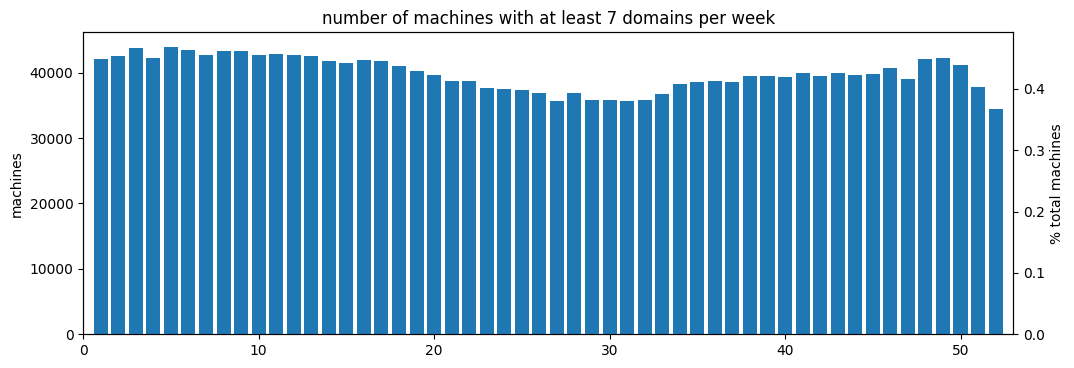

In [69]:
print('how much was dropped by filtering out bad domains and limiting to samples with >= 7 domains?')
print('unfiltered = %s rows' % len(weeks_machines_domains_df))
print('filtered = %s rows' % len(weeks_machines_7domains_df))
dropped_rows = len(weeks_machines_domains_df) - len(weeks_machines_7domains_df)
print('dropped %s = %0.1f%% rows' % (dropped_rows, 100*dropped_rows/len(weeks_machines_domains_df)))

print('\nhow many machines per week after filtering?\n')

print(weeks_machines_7domains.describe())
print(weeks_machines_7domains_pct.describe())

weeks_machines_7domains = weeks_machines_7domains_df.groupby(['week'])['machine_id'].nunique()
weeks_machines_7domains_pct = weeks_machines_7domains \
    / weeks_machines_domains_df.groupby(['week'])['machine_id'].nunique()

fig, ax = plt.subplots(1,1, figsize=(12, 4), dpi=100)
ax.bar(weeks_machines_7domains.index, weeks_machines_7domains)
ax.set_xlim(0, 53)
ax.set_title('number of machines with at least 7 domains per week')
ax.set_ylabel('machines')
ax_pct = ax.twinx()
ax_pct.bar(weeks_machines_7domains_pct.index, weeks_machines_7domains_pct)
_ = ax_pct.set_ylabel('% total machines')


Create set of all domains used in analysis.

This we can use for random domain set creation for the random comparison.

In [70]:
good_domains_set = domains_set - bad_domains
print('total good domains:')
len(good_domains_set)

total good domains:


4351029

### Make FLoC cohorts for sessions data


In [71]:
import prefixLSH

We have 500 panels, 52 weeks of data.

We will compute cohorts covering this broad sampling.

To start with... just looking at:

specific panel ID, random week of data


We take the panel and add in the simhash computed from the machine_id domains.

Note this step will drop / ignore machine,weeks without enough good domains for the simhash calculation.

TODO: consider whether this is in conflict with the stratified panel sampling.

For the given panel, we then assign cohorts by applying prefixLSH.

In [ ]:
import random

In [205]:
def get_panel_week_combo(p, debug=True):
    """
    Returns a panel that combines multiple panel ids (p) from different weeks.
    where panel ids and weeks are randomly sampled without replacement
    and each panel id is combined with one week
    """
    panel_ids = np.random.choice(panels_df.panel_id.unique(), size=p, replace=False)
    weeks = np.random.choice(list(range(1,52+1)), size=p, replace=False)
    if debug:
        print('using panel id, week combos:', list(zip(panel_ids, weeks)))
    pdf = panels_df[panels_df.panel_id.isin(panel_ids)].copy()
    pdf['week'] = pdf.panel_id.map(dict(zip(panel_ids, weeks)))
    pdf = pdf.set_index(['machine_id','week'])
    pdf['simhash'] = weeks_machines_7domains_df.set_index(['machine_id','week'])['simhash']
    return pdf

In [213]:
p = 1
k = 40

panel_df1 = get_panel_week_combo(p)
panel_df1.head()

using panel id, week combos: [(347, 1)]


,,household_income,racial_background,stratify,panel_id,simhash
machine_id,week,,,,,
199812221.0,1,1,1.0,"1.0, 1.0",347,NaN
216515906.0,1,1,1.0,"1.0, 1.0",347,NaN
225731892.0,1,1,1.0,"1.0, 1.0",347,5.079672e+14
170042795.0,1,1,1.0,"1.0, 1.0",347,9.238142e+14
210141851.0,1,1,1.0,"1.0, 1.0",347,1.520057e+14


In [217]:
# grab the panel
# join it with the sessions simhash data
# note we will drop / ignore machine,weeks without sufficient domains for simhash

cohorts_dict = prefixLSH.get_cohorts_dict(panel_df1.dropna()['simhash'].astype(int), min_k=40)
panel_df1['cohort'] = panel_df1['simhash'].map(cohorts_dict)

print("%s cohorts" % panel_df1["cohort"].nunique())
assert(panel_df1["cohort"].max() == panel_df1["cohort"].nunique())

print("%s samples (rows)" % len(panel_week_combo.dropna()))
print("%0.1f avg samples per cohort" % (len(panel_df1.dropna())/panel_df1["cohort"].nunique()))


94 cohorts
55843 samples (rows)
62.7 avg samples per cohort


cohort sizes:
4.0     116
57.0    108
12.0     93
20.0     91
63.0     90
       ... 
60.0     40
15.0     40
53.0     40
38.0     40
27.0     40
Name: cohort, Length: 94, dtype: int64


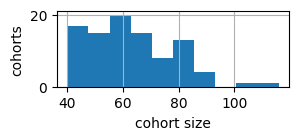

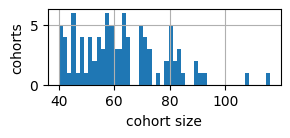

In [218]:
print('cohort sizes:')
print(panel_df1["cohort"].value_counts())

fig,ax = plt.subplots(1,1,figsize=(3,1), dpi=100)
panel_df1["cohort"].value_counts().hist(ax=ax)
plt.ylabel("cohorts")
_ = plt.xlabel("cohort size")
plt.show()
fig,ax = plt.subplots(1,1,figsize=(3,1), dpi=100)
panel_df1["cohort"].value_counts().hist(ax=ax, bins=50)
plt.ylabel("cohorts")
_ = plt.xlabel("cohort size")

#### Look at demographic distribution across cohorts

In [147]:
def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df

In [ ]:
cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)

In [255]:
demo_col = 'racial_background'
demo_avgs = panel_df1.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df1.dropna())
print(demo_avgs[3])
demo_avgs

0.06361323155216285


racial_background
1.0    0.812553
2.0    0.101272
3.0    0.063613
5.0    0.022561
Name: panel_id, dtype: float64

In [258]:
dpi = 100
t = 0.1

def plot_cohort_demo_portions(panel_df, demo_col, demo_value_names_dict):
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    
    for val in demo_value_names_dict:
        print('%s' % demo_value_names_dict[val])
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

        fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")

        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        if demo_mean-t > 0:
            ax.hlines(y=demo_fraction-t, xmin=0, xmax=len(ax.get_xticks()), 
                      linestyles='--', color='black', label='mean - t=0.1')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        #ax.legend()
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        ax.set_ylabel('fraction "%s"' % demo_value_names_dict[val])
        plt.show()
    
    return cohort_demo_portions_df

Looking at race

white
mean fraction white across cohorts = 0.81
fraction white across all users in cohorts = 0.81


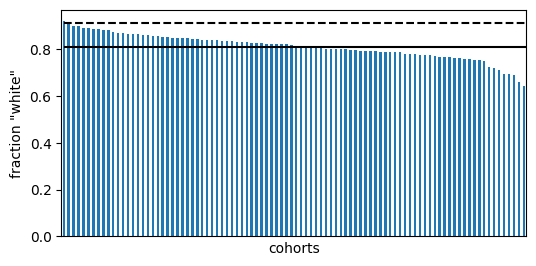

black
mean fraction black across cohorts = 0.10
fraction black across all users in cohorts = 0.10


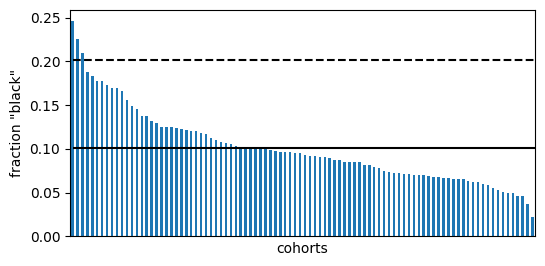

asian
mean fraction asian across cohorts = 0.07
fraction asian across all users in cohorts = 0.06


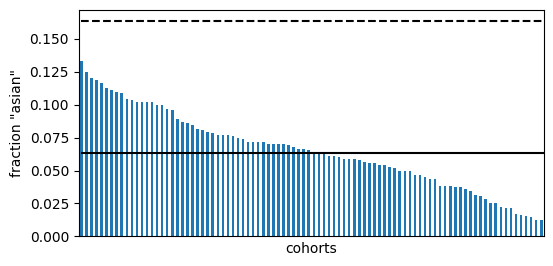

other
mean fraction other across cohorts = 0.03
fraction other across all users in cohorts = 0.02


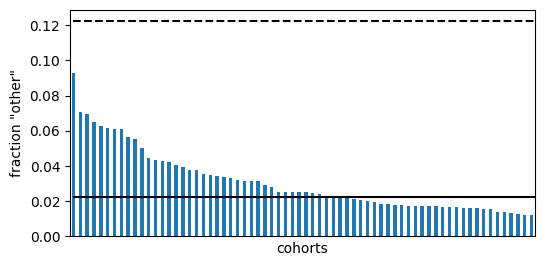

,racial_background,count,total,portion
cohort,,,,
1.0,1.0,29,45,0.644444
1.0,2.0,8,45,0.177778
1.0,3.0,6,45,0.133333
1.0,5.0,2,45,0.044444
2.0,1.0,56,69,0.811594


In [259]:
race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
race1 = plot_cohort_demo_portions(panel_df1, 'racial_background', race_values)
race1.head()

In [260]:
panels_df[panels_df.panel_id==panel_id]['racial_background'].value_counts()/len(panels_df[panels_df.panel_id==panel_id])

1.0    0.784456
2.0    0.133213
3.0    0.052775
5.0    0.029557
Name: racial_background, dtype: float64

Looking at just household income

4    0.292607
3    0.290137
2    0.216532
1    0.200725
Name: household_income, dtype: float64


0 to 25k
mean fraction 0 to 25k across cohorts = 0.18
fraction 0 to 25k across all users in cohorts = 0.17


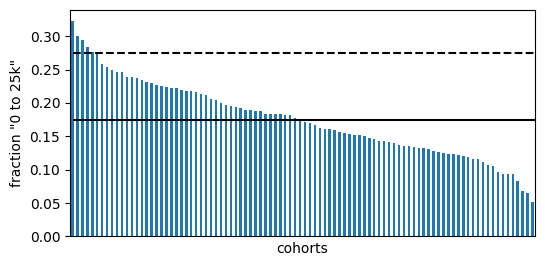

25k to 50k
mean fraction 25k to 50k across cohorts = 0.20
fraction 25k to 50k across all users in cohorts = 0.20


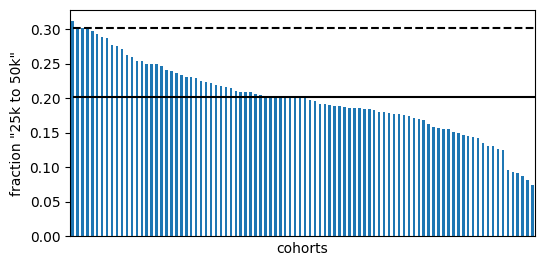

50k to 100k
mean fraction 50k to 100k across cohorts = 0.30
fraction 50k to 100k across all users in cohorts = 0.30


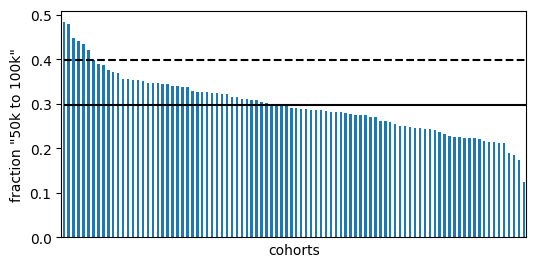

100k +
mean fraction 100k + across cohorts = 0.33
fraction 100k + across all users in cohorts = 0.33


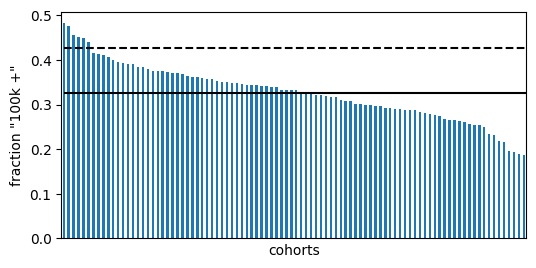

,household_income,count,total,portion
cohort,,,,
1.0,1,10,45,0.222222
1.0,2,13,45,0.288889
1.0,3,10,45,0.222222
1.0,4,12,45,0.266667
2.0,1,13,69,0.188406


In [261]:
hi_values = {1:'0 to 25k', 2:'25k to 50k', 3:'50k to 100k', 4:'100k +'}
print(panels_df[panels_df.panel_id==panel_id]['household_income'].value_counts()/len(panels_df[panels_df.panel_id==panel_id]))
print('\n')
hi1 = plot_cohort_demo_portions(panel_df1, 'household_income', hi_values)
hi1.head()

Looking at combinations of race x household income

In [262]:
panel_df1.head()

,,household_income,racial_background,stratify,panel_id,simhash,cohort
machine_id,week,,,,,,
199812221.0,1,1,1.0,"1.0, 1.0",347,NaN,NaN
216515906.0,1,1,1.0,"1.0, 1.0",347,NaN,NaN
225731892.0,1,1,1.0,"1.0, 1.0",347,5.079672e+14,40.0
170042795.0,1,1,1.0,"1.0, 1.0",347,9.238142e+14,77.0
210141851.0,1,1,1.0,"1.0, 1.0",347,1.520057e+14,11.0


In [263]:
panel_df1['stratify'].value_counts()

4.0, 1.0    2953
3.0, 1.0    2836
2.0, 1.0    2016
1.0, 1.0    1723
1.0, 2.0     530
2.0, 2.0     422
3.0, 2.0     408
4.0, 3.0     269
4.0, 2.0     258
3.0, 3.0     176
3.0, 5.0     104
2.0, 3.0     102
1.0, 3.0      94
1.0, 5.0      91
2.0, 5.0      90
4.0, 5.0      74
Name: stratify, dtype: int64

In [264]:
hi_race_values = {
    "1.0, 1.0": "0 to 25k, white",
    "2.0, 1.0": "25k to 50k, white",
    "3.0, 1.0": "50k to 100k, white",
    "4.0, 1.0": "100k +, white",
    
    "1.0, 2.0": "0 to 25k, black",
    "2.0, 2.0": "25k to 50k, black",
    "3.0, 2.0": "50k to 100k, black",
    "4.0, 2.0": "100k +, black",
    
    "1.0, 3.0": "0 to 25k, asian",
    "2.0, 3.0": "25k to 50k, asian",
    "3.0, 3.0": "50k to 100k, asian",
    "4.0, 3.0": "100k +, asian",
    
    "1.0, 5.0": "0 to 25k, other",
    "2.0, 5.0": "25k to 50k, other",
    "3.0, 5.0": "50k to 100k, other",
    "4.0, 5.0": "100k +, other",
}

0 to 25k, white
mean fraction 0 to 25k, white across cohorts = 0.13
fraction 0 to 25k, white across all users in cohorts = 0.13


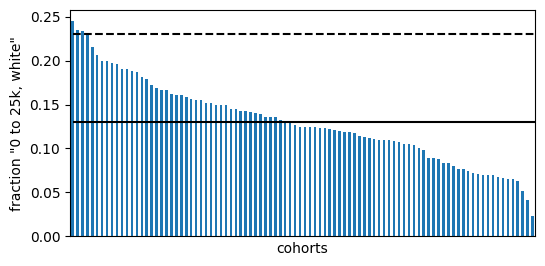

25k to 50k, white
mean fraction 25k to 50k, white across cohorts = 0.16
fraction 25k to 50k, white across all users in cohorts = 0.16


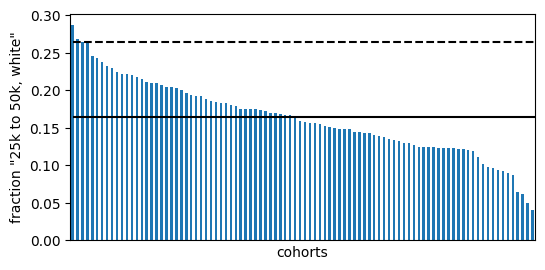

50k to 100k, white
mean fraction 50k to 100k, white across cohorts = 0.24
fraction 50k to 100k, white across all users in cohorts = 0.24


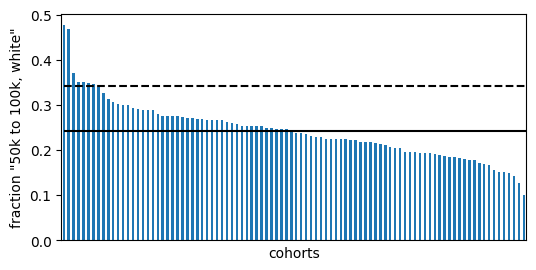

100k +, white
mean fraction 100k +, white across cohorts = 0.28
fraction 100k +, white across all users in cohorts = 0.27


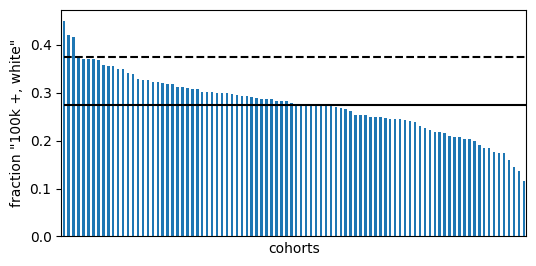

0 to 25k, black
mean fraction 0 to 25k, black across cohorts = 0.04
fraction 0 to 25k, black across all users in cohorts = 0.03


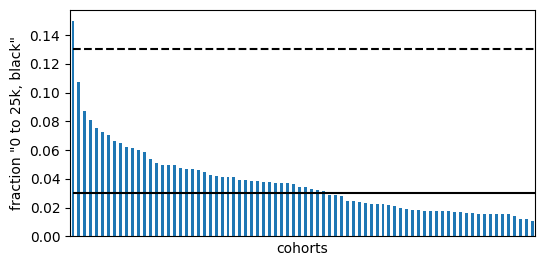

25k to 50k, black
mean fraction 25k to 50k, black across cohorts = 0.03
fraction 25k to 50k, black across all users in cohorts = 0.02


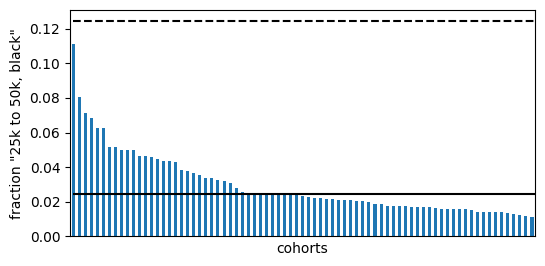

50k to 100k, black
mean fraction 50k to 100k, black across cohorts = 0.03
fraction 50k to 100k, black across all users in cohorts = 0.03


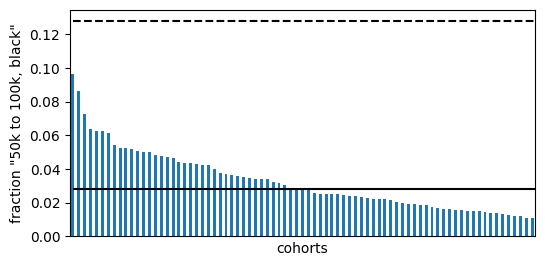

100k +, black
mean fraction 100k +, black across cohorts = 0.03
fraction 100k +, black across all users in cohorts = 0.02


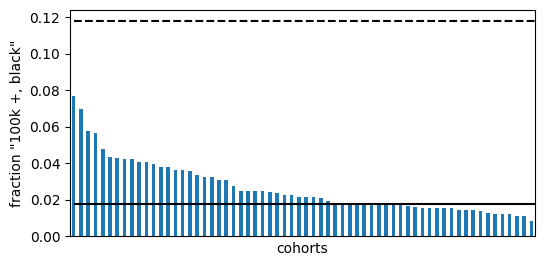

0 to 25k, asian
mean fraction 0 to 25k, asian across cohorts = 0.02
fraction 0 to 25k, asian across all users in cohorts = 0.01


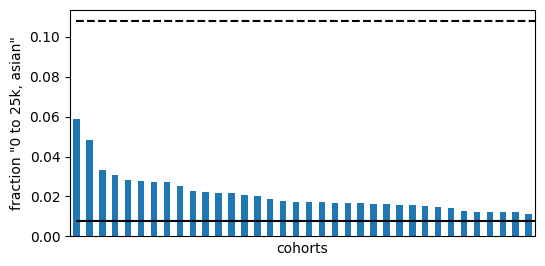

25k to 50k, asian
mean fraction 25k to 50k, asian across cohorts = 0.02
fraction 25k to 50k, asian across all users in cohorts = 0.01


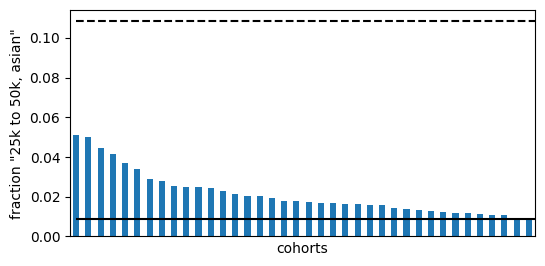

50k to 100k, asian
mean fraction 50k to 100k, asian across cohorts = 0.03
fraction 50k to 100k, asian across all users in cohorts = 0.02


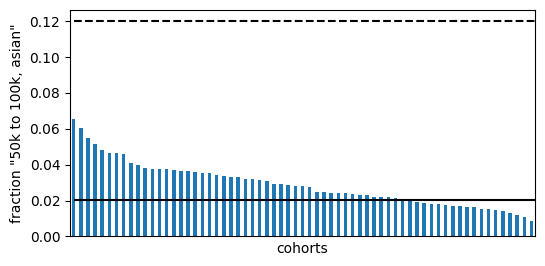

100k +, asian
mean fraction 100k +, asian across cohorts = 0.03
fraction 100k +, asian across all users in cohorts = 0.03


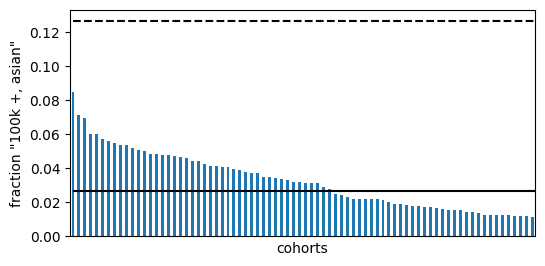

0 to 25k, other
mean fraction 0 to 25k, other across cohorts = 0.02
fraction 0 to 25k, other across all users in cohorts = 0.01


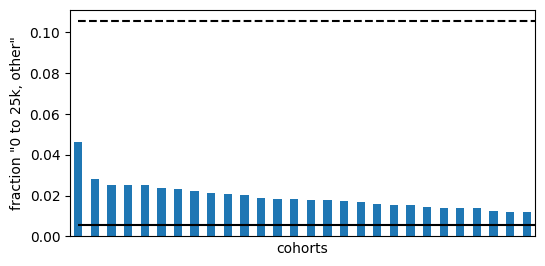

25k to 50k, other
mean fraction 25k to 50k, other across cohorts = 0.02
fraction 25k to 50k, other across all users in cohorts = 0.00


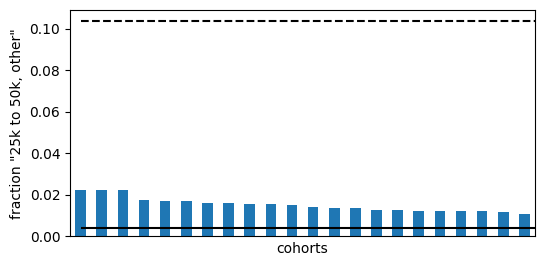

50k to 100k, other
mean fraction 50k to 100k, other across cohorts = 0.02
fraction 50k to 100k, other across all users in cohorts = 0.01


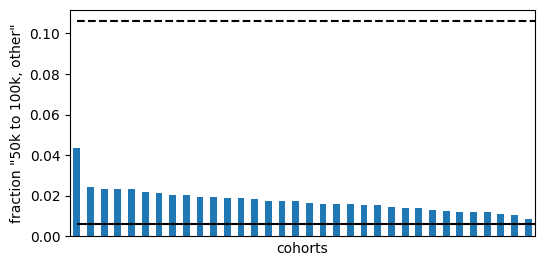

100k +, other
mean fraction 100k +, other across cohorts = 0.02
fraction 100k +, other across all users in cohorts = 0.01


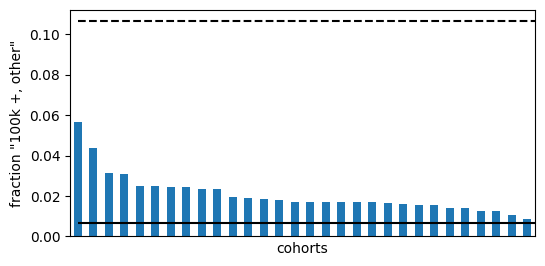

,stratify,count,total,portion
cohort,,,,
1.0,"1.0, 1.0",7,45,0.155556
1.0,"1.0, 2.0",1,45,0.022222
1.0,"1.0, 3.0",1,45,0.022222
1.0,"1.0, 5.0",1,45,0.022222
1.0,"2.0, 1.0",5,45,0.111111
...,...,...,...,...
94.0,"3.0, 1.0",16,70,0.228571
94.0,"3.0, 2.0",1,70,0.014286
94.0,"4.0, 1.0",17,70,0.242857


In [265]:
hi_race1 = plot_cohort_demo_portions(panel_df1, 'stratify', hi_race_values)
hi_race1

Look at "bigger panels" by combining panels. Sample with different weeks.


In [266]:
# make a panel out of p panel ids
panel_week_combo = get_panel_week_combo(20)
cohorts_dict = prefixLSH.get_cohorts_dict(panel_week_combo.dropna()['simhash'].astype(int), min_k=50)
panel_week_combo['cohort'] = panel_week_combo['simhash'].map(cohorts_dict)

print("%s cohorts" % panel_week_combo["cohort"].nunique())
assert(panel_week_combo["cohort"].max() == panel_week_combo["cohort"].nunique())

panel_week_combo.head()

using panel id, week combos: [(371, 45), (418, 50), (120, 16), (382, 15), (431, 3), (38, 24), (75, 1), (449, 8), (494, 17), (397, 11), (296, 46), (387, 35), (201, 47), (232, 21), (244, 2), (285, 9), (416, 19), (178, 31), (355, 22), (450, 29)]
1422 cohorts


,,household_income,racial_background,stratify,panel_id,simhash,cohort
machine_id,week,,,,,,
177954124.0,24,1,1.0,"1.0, 1.0",38,NaN,NaN
213566733.0,24,1,1.0,"1.0, 1.0",38,NaN,NaN
172751926.0,24,1,1.0,"1.0, 1.0",38,NaN,NaN
228049499.0,24,1,1.0,"1.0, 1.0",38,NaN,NaN
216111256.0,24,1,1.0,"1.0, 1.0",38,4.034915e+14,453.0


cohort sizes:
1304.0    191
1303.0    168
1292.0    167
1306.0    156
1305.0    156
         ... 
427.0      50
1122.0     50
644.0      50
1180.0     50
30.0       50
Name: cohort, Length: 1422, dtype: int64


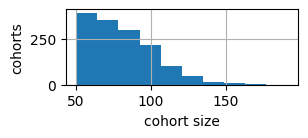

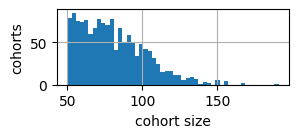

In [267]:
print('cohort sizes:')
print(panel_week_combo["cohort"].value_counts())

fig,ax = plt.subplots(1,1,figsize=(3,1), dpi=100)
panel_week_combo["cohort"].value_counts().hist(ax=ax)
plt.ylabel("cohorts")
_ = plt.xlabel("cohort size")
plt.show()
fig,ax = plt.subplots(1,1,figsize=(3,1), dpi=100)
panel_week_combo["cohort"].value_counts().hist(ax=ax, bins=50)
plt.ylabel("cohorts")
_ = plt.xlabel("cohort size")

white
mean fraction white across cohorts = 0.81
fraction white across all users in cohorts = 0.81


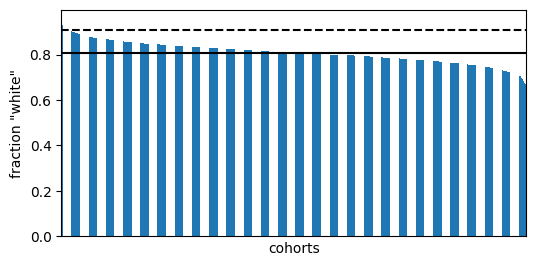

black
mean fraction black across cohorts = 0.11
fraction black across all users in cohorts = 0.11


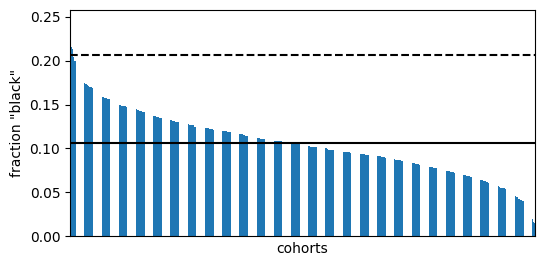

asian
mean fraction asian across cohorts = 0.06
fraction asian across all users in cohorts = 0.06


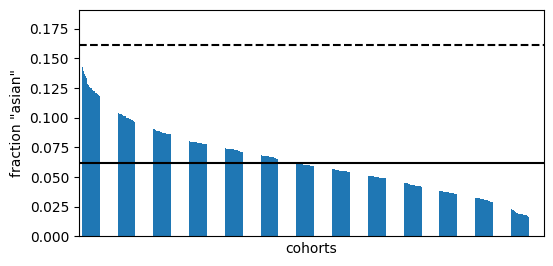

other
mean fraction other across cohorts = 0.03
fraction other across all users in cohorts = 0.02


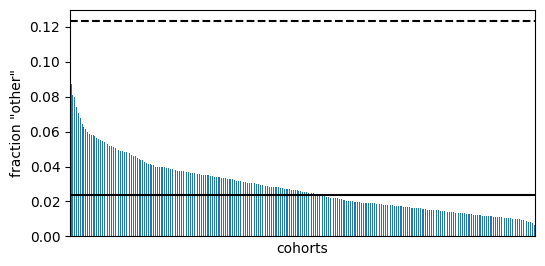

0 to 25k
mean fraction 0 to 25k across cohorts = 0.17
fraction 0 to 25k across all users in cohorts = 0.17


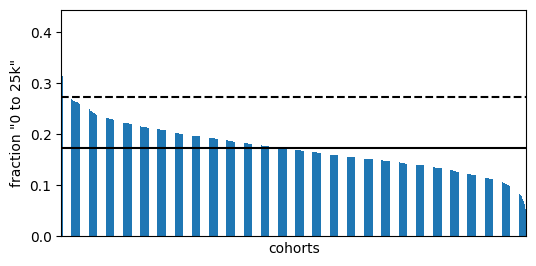

25k to 50k
mean fraction 25k to 50k across cohorts = 0.21
fraction 25k to 50k across all users in cohorts = 0.21


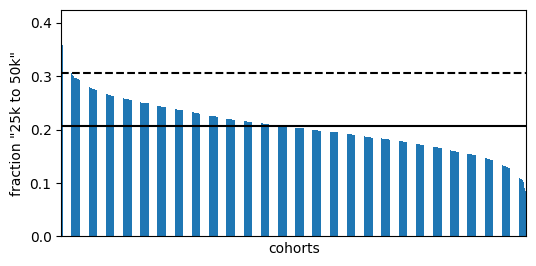

50k to 100k
mean fraction 50k to 100k across cohorts = 0.30
fraction 50k to 100k across all users in cohorts = 0.30


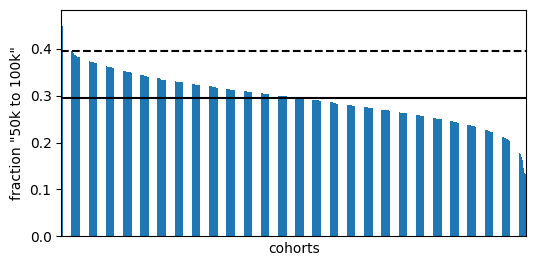

100k +
mean fraction 100k + across cohorts = 0.32
fraction 100k + across all users in cohorts = 0.32


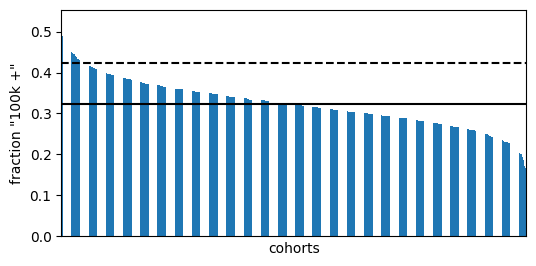

0 to 25k, white
mean fraction 0 to 25k, white across cohorts = 0.13
fraction 0 to 25k, white across all users in cohorts = 0.13


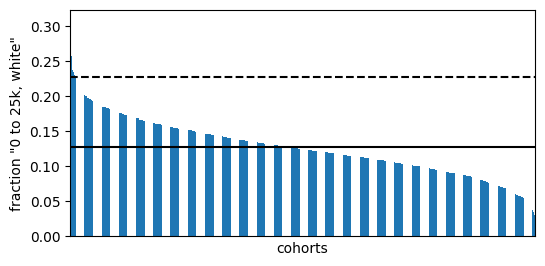

25k to 50k, white
mean fraction 25k to 50k, white across cohorts = 0.16
fraction 25k to 50k, white across all users in cohorts = 0.16


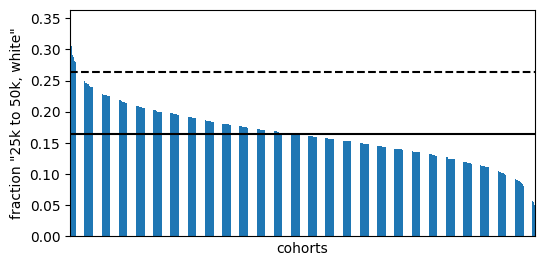

50k to 100k, white
mean fraction 50k to 100k, white across cohorts = 0.24
fraction 50k to 100k, white across all users in cohorts = 0.24


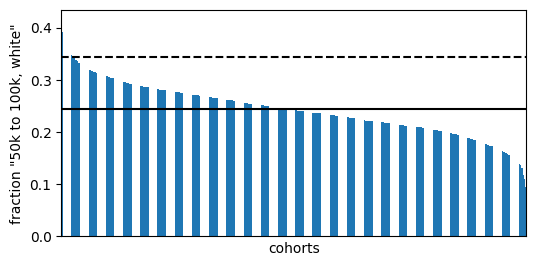

100k +, white
mean fraction 100k +, white across cohorts = 0.27
fraction 100k +, white across all users in cohorts = 0.27


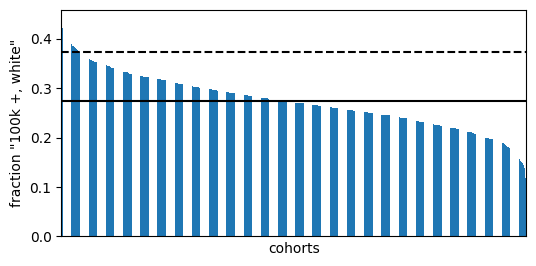

0 to 25k, black
mean fraction 0 to 25k, black across cohorts = 0.04
fraction 0 to 25k, black across all users in cohorts = 0.03


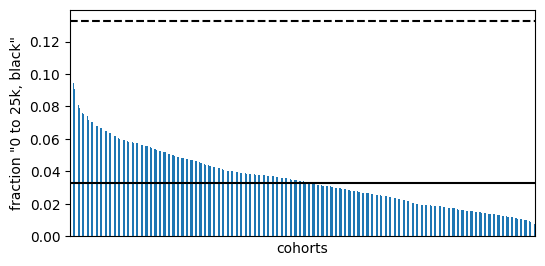

25k to 50k, black
mean fraction 25k to 50k, black across cohorts = 0.03
fraction 25k to 50k, black across all users in cohorts = 0.03


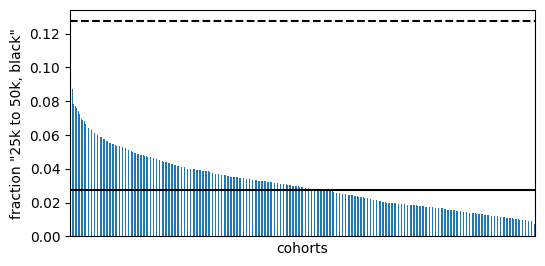

50k to 100k, black
mean fraction 50k to 100k, black across cohorts = 0.03
fraction 50k to 100k, black across all users in cohorts = 0.03


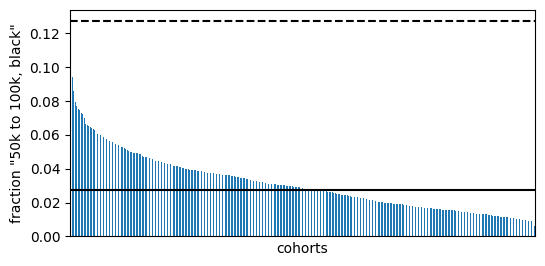

100k +, black
mean fraction 100k +, black across cohorts = 0.02
fraction 100k +, black across all users in cohorts = 0.02


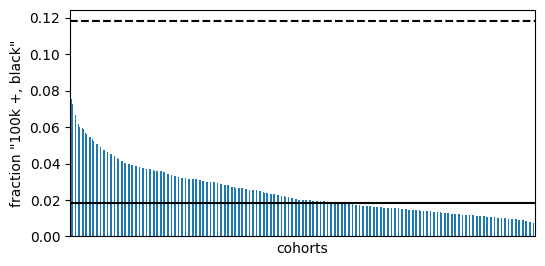

0 to 25k, asian
mean fraction 0 to 25k, asian across cohorts = 0.02
fraction 0 to 25k, asian across all users in cohorts = 0.01


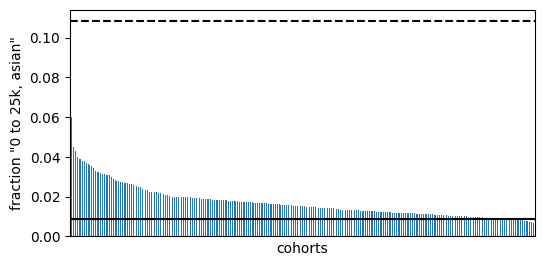

25k to 50k, asian
mean fraction 25k to 50k, asian across cohorts = 0.02
fraction 25k to 50k, asian across all users in cohorts = 0.01


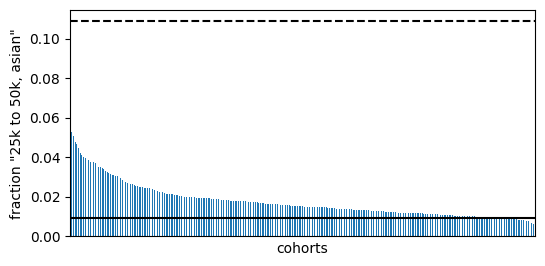

50k to 100k, asian
mean fraction 50k to 100k, asian across cohorts = 0.02
fraction 50k to 100k, asian across all users in cohorts = 0.02


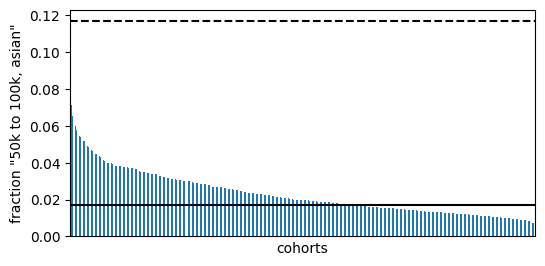

100k +, asian
mean fraction 100k +, asian across cohorts = 0.03
fraction 100k +, asian across all users in cohorts = 0.03


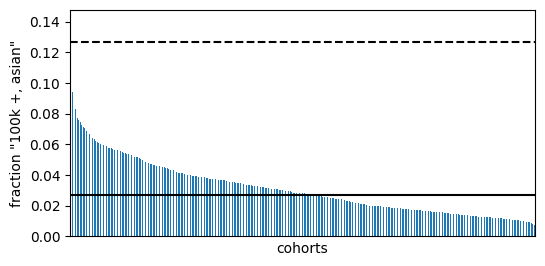

0 to 25k, other
mean fraction 0 to 25k, other across cohorts = 0.02
fraction 0 to 25k, other across all users in cohorts = 0.01


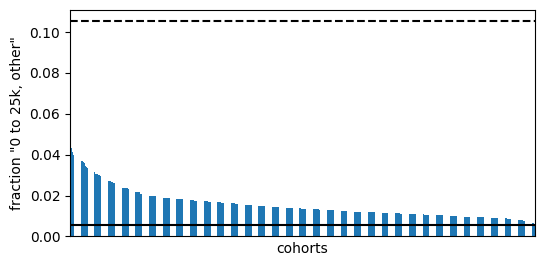

25k to 50k, other
mean fraction 25k to 50k, other across cohorts = 0.02
fraction 25k to 50k, other across all users in cohorts = 0.01


In [ ]:
plot_cohort_demo_portions(panel_week_combo, 'racial_background', race_values)
hi = plot_cohort_demo_portions(panel_week_combo, 'household_income', hi_values)
plot_cohort_demo_portions(panel_week_combo, 'stratify', hi_race_values)